### Essai de Natural Language processing (NLP)

Political Bias Detection

S: "Biased left" (0), N : "Neutral"(1), V: "biased right"(2)

In [95]:

import matplotlib.pyplot as plt
import seaborn as sns
#NLP libraries
import nltk
from gensim.models import Doc2Vec
import gensim
from gensim.models.doc2vec import TaggedDocument
#Machine learning libraries
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#Helper libraries
import multiprocessing
import numpy as np
import pandas as pd
import math
from bs4 import BeautifulSoup
import re
import os


nltk.download('punkt', download_dir="./data_model/")

[nltk_data] Downloading package punkt to ./data_model/...
[nltk_data]   Package punkt is already up-to-date!


True

In [96]:
dataset = pd.read_csv('./data_model/dataset.csv', header=0)
dataset = dataset.drop('url',axis=1)
dataset = dataset.iloc[np.random.permutation(len(dataset))]
print(dataset)

                                                content bias
4348  Претседателот Стево Пендаровски посети волонте...    N
3262  Куманово 16676, Активни 5 Битола 15654, Активн...    N
4720  Времето денеска ќе биде сончево со мала до уме...    N
1814  Граѓаните во Република Македонија повторно ќе ...    V
652   Еден од врвните приоритети на СДСМ во време на...    S
...                                                 ...  ...
670   Некој во Белиот дворец треба да му каже на Хри...    S
296   Тоа што беше најавувано како активната блокада...    S
2882  По тешката корупција за избор на фаворитот на ...    V
4457  Еднакви услови за сите ученици во Северна Маке...    N
3311  Бетон вели – разликата ќе ви ја платиме. Два м...    N

[5735 rows x 2 columns]


In [97]:
dataset['bias'] = dataset['bias'].replace(['S','N','V'],[0,1,2])
dataset.head(10)

,content,bias
4348,Претседателот Стево Пендаровски посети волонте...,1
3262,"Куманово 16676, Активни 5 Битола 15654, Активн...",1
4720,Времето денеска ќе биде сончево со мала до уме...,1
1814,Граѓаните во Република Македонија повторно ќе ...,2
652,Еден од врвните приоритети на СДСМ во време на...,0
4304,Цената на електричната енергија нема да поскап...,1
4792,Патријархот Порфириј на заедничката литургија ...,1
5235,Од 1 до 5 часот на територијата на Општина Кар...,1
2412,"Портпаролот на ВМРО-ДПМНЕ, Димче Арсовски одго...",2
3703,Салата од која се слушаа звуците на домашни и ...,1


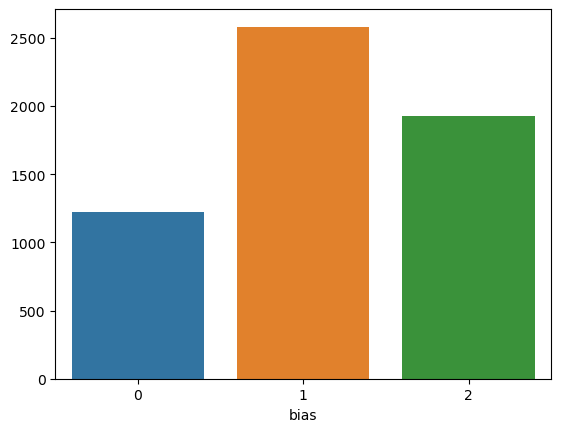

In [98]:
bias_vals = dataset['bias'].value_counts()
plt.figure()
sns.barplot(x=bias_vals.index, y=bias_vals.values)
plt.show()

_stop word russes (notre dataset de train est russe pour le moment)

In [99]:
_stopwords = set(u"""
беше
еден
едно
јас
рече
сите
сум
ние
сме
овде
исто
така
на
и
во
се
го
не
да
е
што
од
со
за
или
тоа
ја
по
тој
но
а
ги
до
таа
му
кои
па
нив
ни
ќе
кој
итн
бил
кај
ова
врз
над
тие
a
две
би
она
неа
си
кое
ако
два
има
в
како
само
дека
една
туку
кога
сега
ми
потоа
низ
ти
кон
додека
веќе
нешто
него
уште
таму
ли
под
беа
ме
некој
ништо
тука
пред
им
каде
повторно
ниту
биде
толку
никогаш
мене
дали
тогаш
своите
сето
без
нема
околу
многу
полека
секогаш
зошто
те
добро
можеби
колку
можеше
нивните
преку
миг
знам
малку
вратата
ох
навистина
оваа
покрај
повеќе
овој
сеуште
имаше
својата
неговите
неговата
друго
зашто
немаше
воопшто
понекогаш
ах
зад
еднаш
својот
дури
себе
ви
токму
зарем
сте
било
сосема
секој
неговото
друг
мошне
ајде
можел
може
која
при
пак
сè
други
треба
ама
после
некоја
нас
бе
никој
одма
сѐ
ај
нѐ
неколку
вие
оние
мора
оди
еј
""".strip().split('\n'))

Cleaning dataset:


In [100]:
def clean(text):  #Removing unecessary punctuation and all lower case.
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = text.replace('„','')
    text = text.replace('“','')
    text = text.replace('"','')
    text = text.replace('\'','')
    text = text.replace('-','')
    text = text.lower()
    return text

def remove_stopwords(content):
    for word in _stopwords:
        content = content.replace(' '+word+' ',' ')
    return content

dataset['content'] = dataset['content'].apply(clean)
dataset['content'] = dataset['content'].apply(remove_stopwords)

C:\Users\Adrien\AppData\Local\Temp\ipykernel_4072\2298218591.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


Splitting test / train data (20% test)

In [101]:
train, test = train_test_split(dataset, test_size=0.2)

Transforming language to vectors
 

In [102]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 3:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['content']), tags=  [r.bias]), axis=1)
test_tagged = test.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['content']), tags=[r.bias]), axis=1)

PV-DBOW or PV-DM (PV-DBOW works better for short text, distributed bag of words)

In [103]:
print(train_tagged.values)

[TaggedDocument(words=['тажен', 'ден', 'македонското', 'здравство', 'чаир', 'почина', 'годишна', 'родилка', 'породување', 'битола', 'годишна', 'девојка', 'притоа', 'познати', 'детално', 'причините', 'смртта', 'присутна', 'македонското', 'здравство', 'венко', 'филипче', 'награден', 'ноемвриска', 'награда', 'шилегов', 'здравството', 'ветуваше', 'премиерот', 'заминување', 'контрола', 'македонското', 'здравство', 'филипче', 'вели', 'луѓе', 'загинаа', 'струен', 'кабел', 'тетово', 'обвинителството', 'вели', 'крив', 'денес', 'трагичен', 'ден', 'околностите', 'починаа', 'овие', 'луѓе', 'испита', 'власта', 'заев', 'способна', 'контрола', 'системот', 'распаѓање'], tags=[2])
 TaggedDocument(words=['охрид', 'денеска', 'почнува', 'дводневната', 'меѓународна', 'конференција', 'преспа', 'форум', 'дијалог', 'организација', 'министерството', 'надворешни', 'работи', 'чие', 'овогодинешно', 'издание', 'носи', 'името', 'градењето', 'иднината', 'западниот', 'балкан', 'современата', 'безбедносна', 'архитекту

In [104]:
cores = multiprocessing.cpu_count()
model = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, sample=0, min_count=2, workers=cores) # PV-DBOW


model.build_vocab(train_tagged.values)  #The model builds his vocabulary on the training set
model.train(utils.shuffle(train_tagged.values), #model train on a mixed trained values and 30 steps
total_examples=len(train_tagged.values),epochs=30)  

model.save("./data_model/doc2vec_articles_0.model")


Using trained model (PV-DBOW)

In [105]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    classes, features = zip(*[(doc.tags[0],
      model.infer_vector(doc_words=doc.words, epochs=20)) for doc in sents]) #steps=epochs increase steps for better precision but more running time
    return features, classes

# PV_DBOW encoded text

train_x_0, train_y_0 = vec_for_learning(model, train_tagged)
test_x_0, test_y_0 = vec_for_learning(model, test_tagged)

### Classification methods : Naive Bayes, RandomForest, SVM, CNN ?

SVM parait bien dans le cas de classification d'articles :

In [106]:
#Helper function for calculating accuracy on the test set.
def acc(true, pred):
  acc = 0
  for x,y in zip(true,pred):
    if(x == y): acc += 1
  return acc/len(pred)

In [107]:
svc_0 = SVC()

svc_0.fit(train_x_0,train_y_0)
print(acc(test_y_0,svc_0.predict(test_x_0))) #Accuracy of model depending on know y_true and y_predict

0.9459459459459459


### Importing data from project to predict Political Bias

In [108]:
text_file_dir="./data/wikispeedia_articles_plaintext/plaintext_articles/"
file_data=[]

for filename in os.listdir(text_file_dir):
    with open(os.path.join(text_file_dir, filename), "r") as file:
        content = file.read()
    
        # Split the content into lines to remove the header
    lines = content.split('\n')

    #Removing the header (line 0)
    if lines:
        lines.pop(0)

    # Making it an array and removing all \n
    content = '\n'.join(lines)
    content = content.replace("\n", " ")


    new_file_content= {"text_content": content}
    
    file_data.append(new_file_content)

project_data = pd.DataFrame(file_data)

project_data

,text_content
0,Áedán mac Gabráin 2007 Schools Wikipedia Sel...
1,Åland 2007 Schools Wikipedia Selection. Rela...
2,Édouard Manet 2007 Schools Wikipedia Selecti...
3,Éire 2007 Schools Wikipedia Selection. Relat...
4,Óengus I of the Picts 2007 Schools Wikipedia...
...,...
4599,Zirconium 2007 Schools Wikipedia Selection. ...
4600,Zoroaster 2007 Schools Wikipedia Selection. ...
4601,Zuid-Gelders 2007 Schools Wikipedia Selectio...
4602,Zulu 2007 Schools Wikipedia Selection. Relat...


In [109]:
_stopwords = set(u"""
a
an
and
the
in
of
on
for
with
as
by
to
at
is
it
that
was
were
be
been
have
has
do
does
I
you
he
she
we
they
not
can
will
should
would
could
may
might
must
shall
""".strip().split('\n'))

Cleaning the data and removing useless word for prediction

In [110]:
project_data['text_content'] = project_data['text_content'].apply(clean)
project_data['text_content'] = project_data['text_content'].apply(remove_stopwords)

Putting lowercase and tokenize the text

In [111]:
project_tagged = project_data.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['text_content']), tags=  []), axis=1)

In [112]:
project_tagged

0       ([áedán, mac, gabráin, 2007, schools, wikipedi...
1       ([åland, 2007, schools, wikipedia, selection, ...
2       ([édouard, manet, 2007, schools, wikipedia, se...
3       ([éire, 2007, schools, wikipedia, selection, r...
4       ([óengus, picts, 2007, schools, wikipedia, sel...
                              ...                        
4599    ([zirconium, 2007, schools, wikipedia, selecti...
4600    ([zoroaster, 2007, schools, wikipedia, selecti...
4601    ([zuidgelders, 2007, schools, wikipedia, selec...
4602    ([zulu, 2007, schools, wikipedia, selection, r...
4603    ([spectrum, 2007, schools, wikipedia, selectio...
Length: 4604, dtype: object

In [113]:
def vectorizing_project_data(model, tagged_docs):
    sents = tagged_docs.values
    features = [model.infer_vector(doc.words, epochs=20) for doc in sents]
    return features

project_vector=vectorizing_project_data(model, project_tagged)

Prediction of Classes:

In [116]:
prediction=svc_0.predict(project_vector)
print(np.unique(prediction))
print(len(project_data), len(prediction))
project_data["Bias"]=prediction

[1 2]
4604 4604


In [115]:
project_data[project_data["Bias"]==2]

,text_content,Bias
1349,elementary group theory 2007 schools wikipedi...,2


Le modèle prédit que tous les articles de notre dataset sont neutres sauf un qui est de droite :)))

Il faut trouver un vrai dataset pour entrainer le modèle

--> Trouver un dataset anglais qui classifie le biais politique d'articles (pas obligatoirement de 0-2, peut avoir d'autres classifications)

--> Ou alors on split notre dataset (4063 Articles) et on définit un biais politique sur certains que l'on utilise pour train notre modèle (problèmes : subjectivité, difficile à faire)